In [1]:
from f_data_prep import *
from f_drosophila_infer import *
from f_train import *

In [2]:
data_complete = np.loadtxt('../data_complete.txt')
data_bin = np.vsplit(data_complete, 6)
data_init = np.vstack([data_bin[i] for i in range(5)])
data_diff = make_data_diff(data_complete, 6)

In [3]:
def infer_train_test(X, y, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    error_list=[]
    w_list=[]
    sigma_list=[]
    bias_list=[]
    for (tr_ind, te_ind) in (kfold.split(y)):
        X_tr, y_tr = X[tr_ind], y[tr_ind]
        X_te, y_te = X[te_ind], y[te_ind]
        
        y_te_sum_sq = np.sum(np.abs(y_te)**2, axis=0)
        w, sigma, bias = infer_drosophila(X_tr, y_tr, max_iter=1000, power=1)
        y_pred = np.tanh(bias + X_te.dot(w)) + sigma*npr.normal(size=(1,99))
        error = np.sqrt(np.sum(np.abs(y_te - y_pred)**2, axis=0)/y_te_sum_sq)
        error_list.append(error)
        w_list.append(w)
        sigma_list.append(sigma)
        bias_list.append(bias)
    return [np.mean(error_list, axis=0), np.std(error_list, axis=0), w_list, sigma_list, bias_list]

### shuffle data, iterate 10 times to get 10 different w, sigma, and bias

In [4]:
# X, y = shuffle(data_init, data_diff)
# infer_list = infer_train_test(X, y, kf=10)

In [5]:
# with open('./pickles/infer_list.pkl', 'wb') as f:
#     pickle.dump(infer_list, f)

In [3]:
with open('./pickles/infer_list.pkl', 'rb') as f:
    infer_list = pickle.load(f)

### plot mean(error) and std(error) of the testing sets

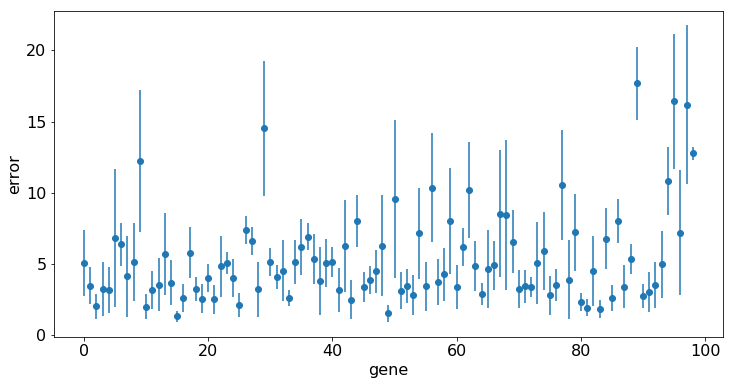

In [4]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.errorbar(range(99), infer_list[0], yerr=infer_list[1], fmt='o')
plt.xlabel('gene')
plt.ylabel('error')
plt.show()

### error of each gene at each time$_{diff}$

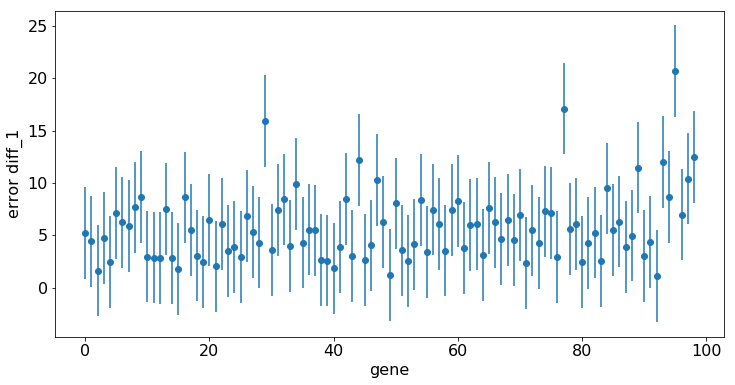

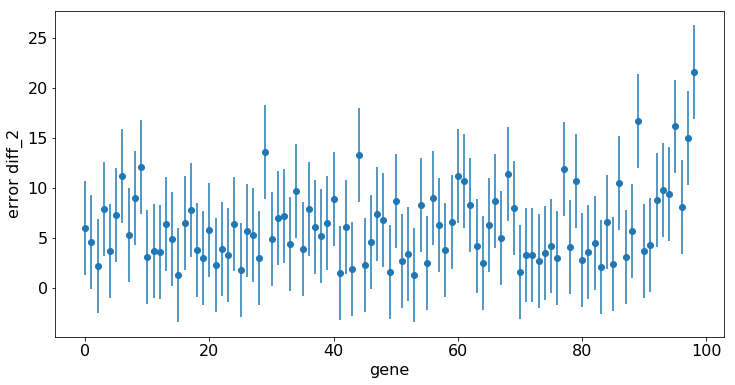

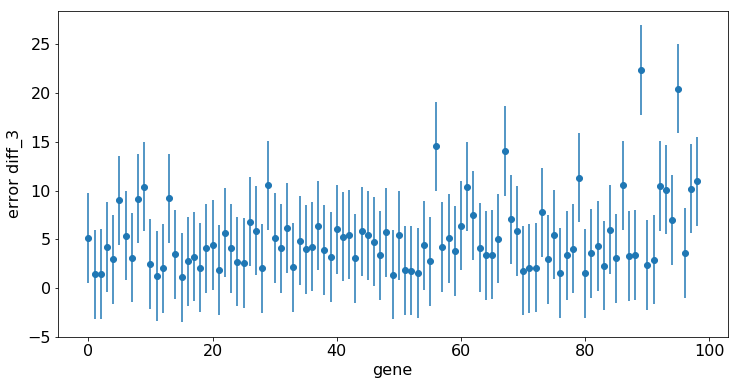

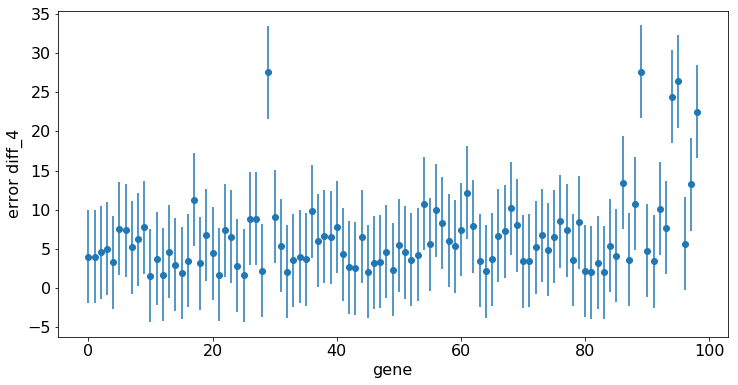

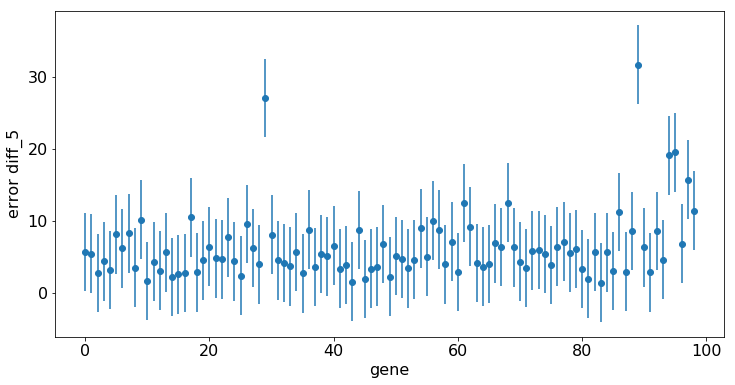

In [12]:
w, sigma, bias = infer_list[2], infer_list[3], infer_list[4]
diff_pred = [np.tanh(bias[i] + data_init.dot(w[i])) + sigma[i]*npr.normal(size=(1,99)) for i in range(10)]
diff_bin = np.vsplit(np.copy(data_diff), 5)
diff_pred_bin = [np.vsplit(diff_pred[i], 5) for i in range(10)]
diff_sum_sq = [np.sum(np.abs(diff_bin[i])**2, axis=0) for i in range(5)]
error_time = [[np.sqrt(np.sum(np.abs(diff_bin[i] - diff_pred_bin[j][i])**2, axis=0)/ diff_sum_sq[i]) for j in range(10)]\
              for i in range(5)]

for i in range(5):
    plt.figure(figsize=(12,6))
    plt.errorbar(range(99), np.mean(error_time[i], axis=0), yerr=np.std(error_time[i]), fmt='o')
    plt.xlabel('gene')
    plt.ylabel('error diff_%s' % (i+1))
#     print(np.mean(np.mean(error_time[i], axis=0)))
plt.show()

### error of each gene across all time and cells

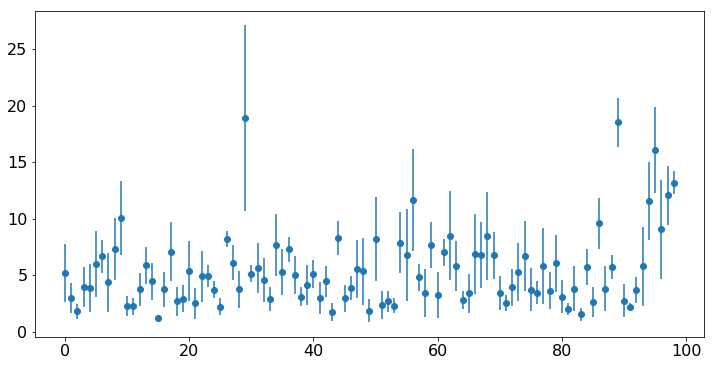

In [9]:
error = [np.sqrt(np.sum(np.abs(data_diff - diff_pred[i])**2, axis=0)/np.sum(np.abs(data_diff)**2, axis=0)) for i in range(10)]
plt.figure(figsize=(12,6))
plt.errorbar(range(99), np.mean(error, axis=0), np.std(error, axis=0), fmt='o')
plt.show()

### error of all genes in each cell, across all time

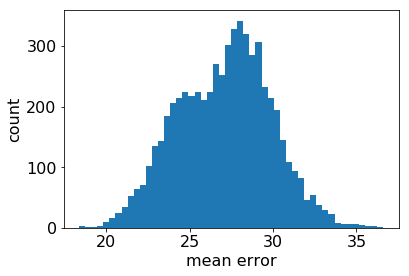

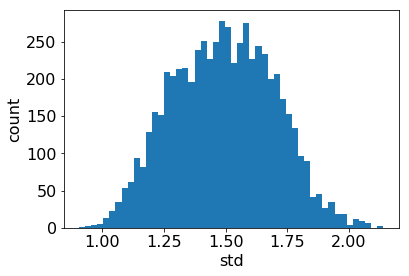

In [10]:
diff_sum_sq = np.sum(np.abs(data_diff)**2, axis=1)
error = [np.sqrt(np.sum(np.abs(data_diff - diff_pred[i])**2, axis=1)/diff_sum_sq) for i in range(10)]
error_bin = [np.vsplit(error[i][:,None], 5) for i in range(10)]
error_cell=[np.sum(error_bin[i], axis=0) for i in range(10)]
mean_error_cell = np.mean(error_cell, axis=0)
std_error_cell = np.std(error_cell, axis=0)

plt.hist(mean_error_cell, bins=50)
plt.xlabel('mean error')
plt.ylabel('count')
plt.show()
plt.hist(std_error_cell, bins=50)
plt.xlabel('std')
plt.ylabel('count')
plt.show()

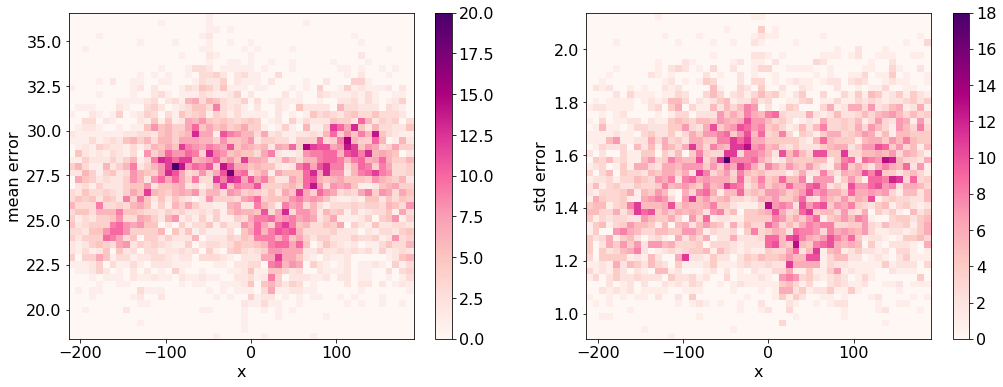

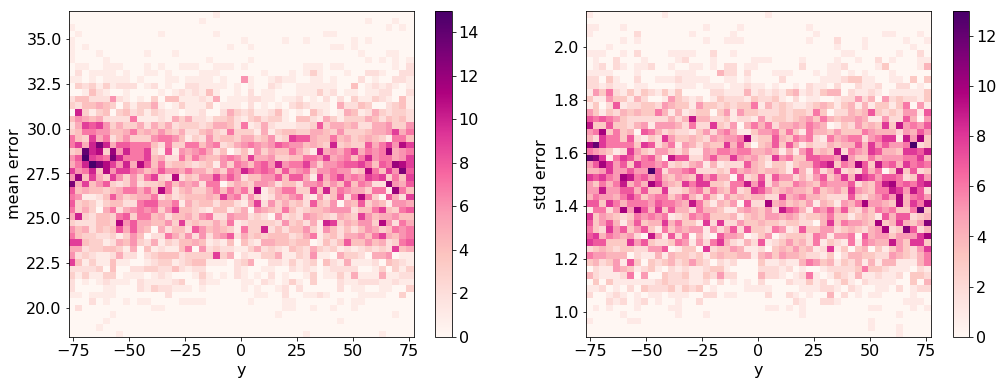

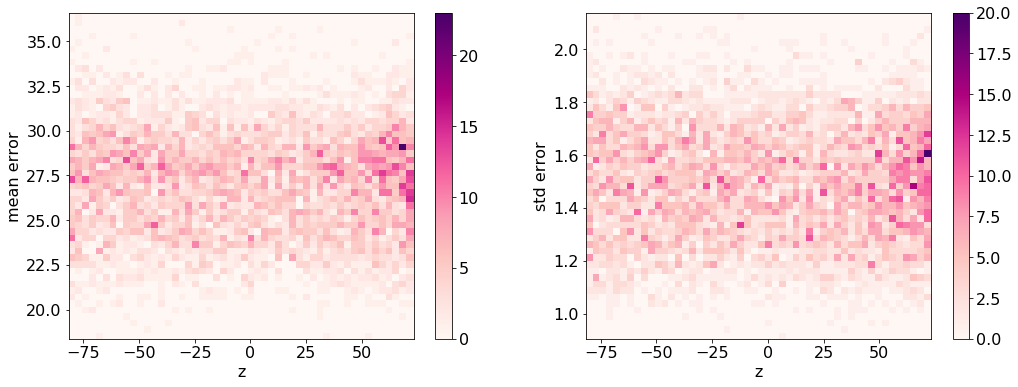

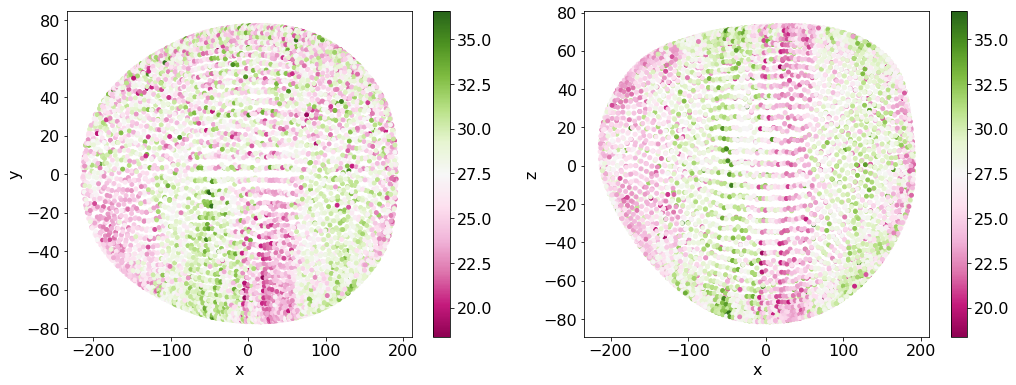

In [11]:
raw_data = np.loadtxt('../dmel_data.txt').T
xyz = raw_data[:,:3]
# plt.figure(figsize=(7,6))
# plt.hist2d(xyz[:,0], mean_error_cell.flatten(), bins=50, cmap=plt.cm.RdPu)
# plt.colorbar(aspect=30)
# plt.xlabel('x-coordinate')
# plt.ylabel('mean_error')
# plt.figure(figsize=(7,6))
# plt.hist2d(xyz[:,1], mean_error_cell.flatten(), bins=50, cmap=plt.cm.RdPu)
# plt.colorbar(aspect=30)
# plt.xlabel('y-coordinate')
# plt.ylabel('mean_error')
# plt.figure(figsize=(7,6))
# plt.hist2d(xyz[:,2], mean_error_cell.flatten(), bins=50, cmap=plt.cm.RdPu)
# plt.colorbar(aspect=30)
# plt.xlabel('z-coordinate')
# plt.ylabel('mean_error')
# plt.show()

xlabels=['x', 'y', 'z']
ylabels=['mean error', 'std error']
for i in range(3):
    fig, ax = plt.subplots(1,2, figsize=(17,6))
    ax0 = ax[0].hist2d(xyz[:,i], mean_error_cell.flatten(), bins=50, cmap=plt.cm.RdPu)
    plt.colorbar(ax0[3], ax=ax[0])
    ax[0].set_xlabel(xlabels[i])
    ax[0].set_ylabel(ylabels[0])
    ax1 = ax[1].hist2d(xyz[:,i], std_error_cell.flatten(), bins=50, cmap=plt.cm.RdPu)
    plt.colorbar(ax1[3], ax=ax[1])
    ax[1].set_xlabel(xlabels[i])
    ax[1].set_ylabel(ylabels[1])

fig = plt.figure(figsize=(17,6))
ax = fig.add_subplot(1,2,1)
xy = ax.scatter(xyz[:,0], xyz[:,1], c=mean_error_cell.flatten(), s=15, cmap=plt.cm.PiYG)
plt.colorbar(xy)
ax.set_xlabel(xlabels[0])
ax.set_ylabel(xlabels[1])
ax = fig.add_subplot(1,2,2)
xz = ax.scatter(xyz[:,0], xyz[:,2], c=mean_error_cell.flatten(), s=15, cmap=plt.cm.PiYG)
plt.colorbar(xz)
ax.set_xlabel(xlabels[0])
ax.set_ylabel(xlabels[2])
plt.show()

<IPython.core.display.Javascript object>


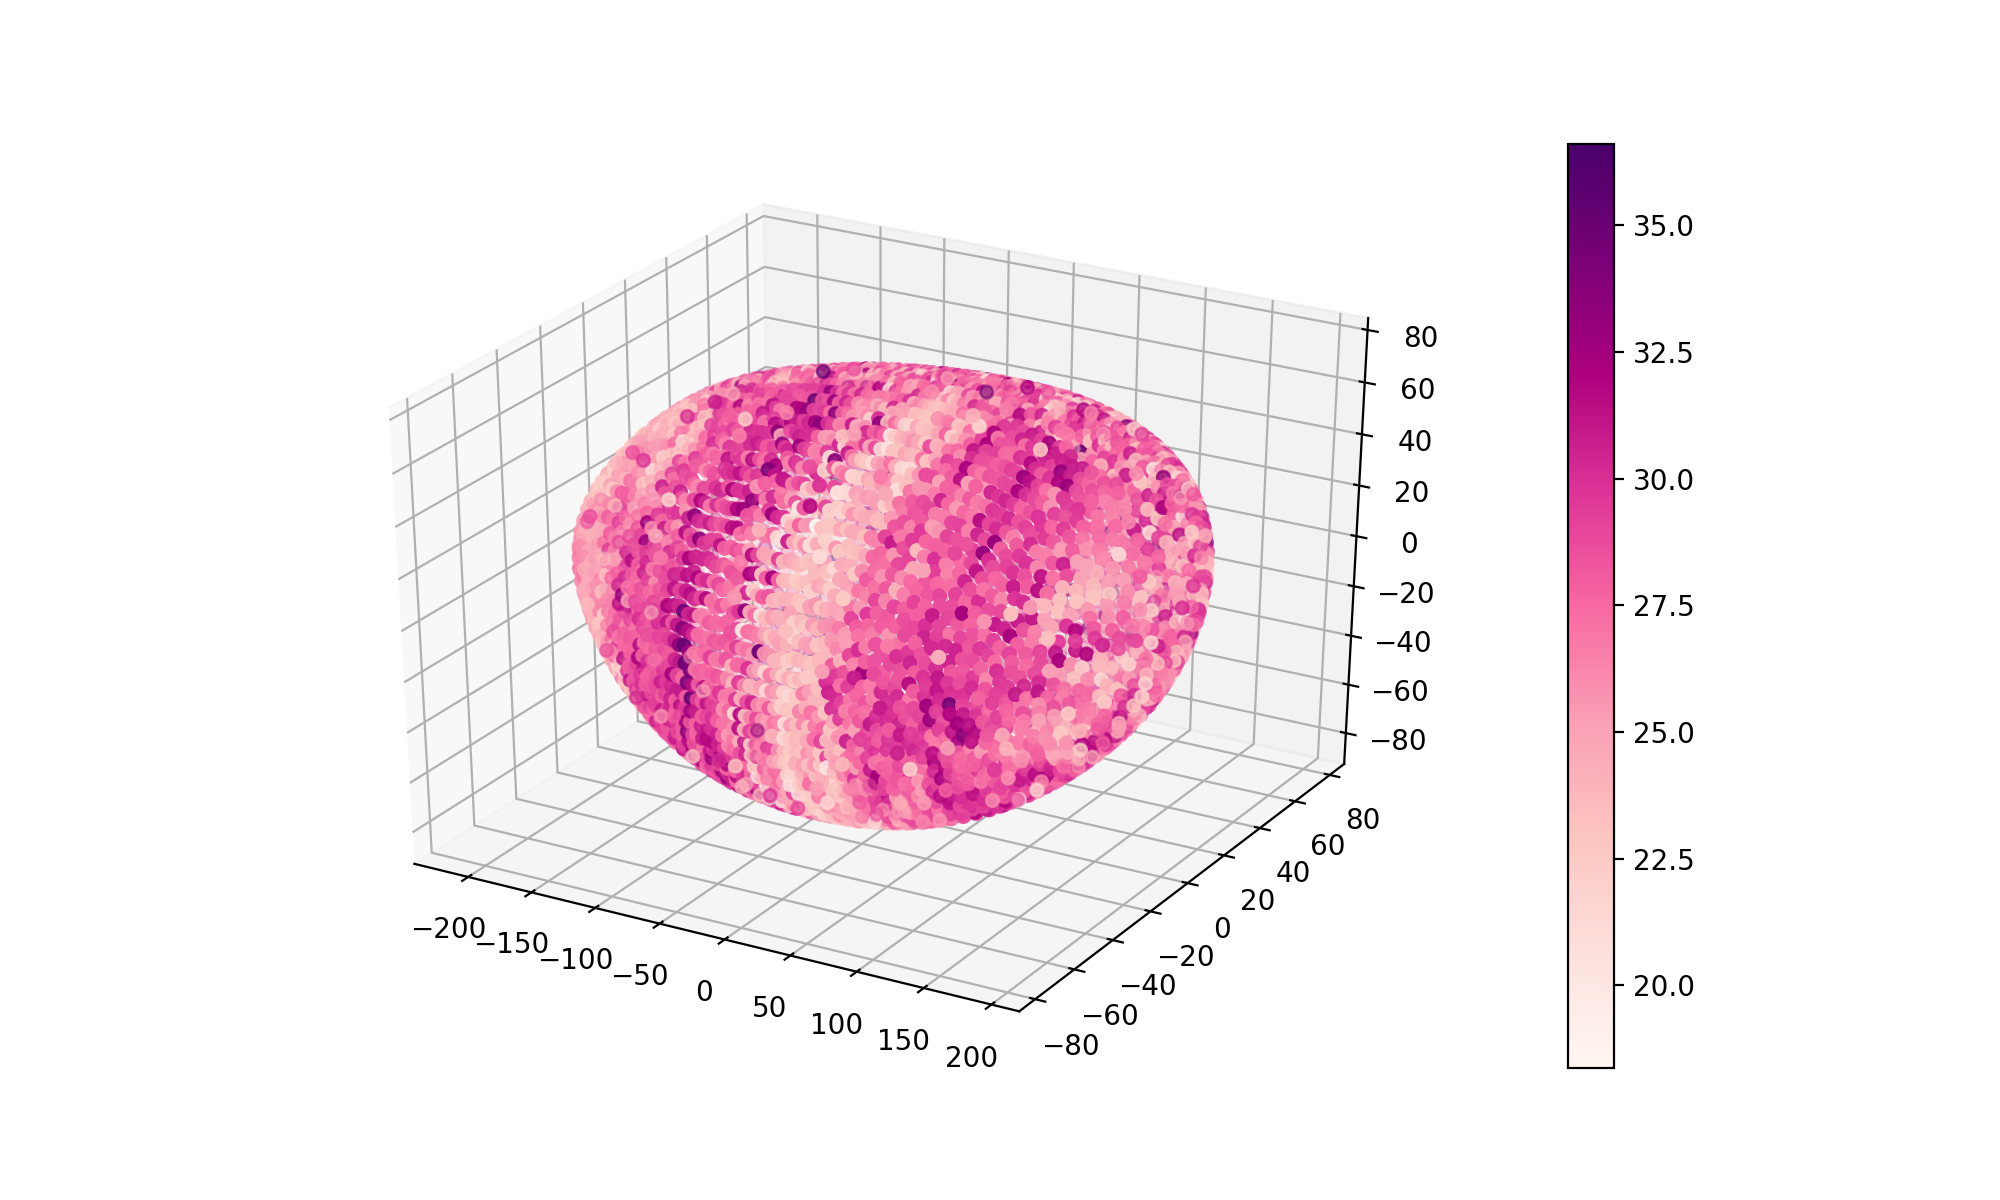

In [12]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
em=ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=mean_error_cell.flatten(), cmap='RdPu')
plt.colorbar(em)
plt.show()
